In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import spacy
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
import matplotlib.pyplot as plt
from collections import Counter


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

data = pd.read_csv('/kaggle/input/bankOffers/Transaction_Naration_Data_Set.csv')  # Replace 'transactions.csv' with the actual filename

# Perform any necessary preprocessing steps, such as removing noise or irrelevant characters


/kaggle/input/bankOffers/Transaction_Naration_Data_Set.csv


In [8]:
data.describe()

,Unnamed: 0,AC_ID,AMOUNT
count,2.254676e+07,2.254676e+07,2.254676e+07
mean,1.127338e+07,2.765147e+06,2.075528e+04
std,6.508689e+06,1.984404e+06,8.234750e+04
min,0.000000e+00,1.000000e+00,1.000000e-02
25%,5.636689e+06,6.461500e+05,6.000000e+02
50%,1.127338e+07,2.942007e+06,1.500000e+03
75%,1.691007e+07,4.529672e+06,7.000000e+03
max,2.254676e+07,6.395404e+06,4.150000e+07


In [9]:
def contains_english_words(text):
    if isinstance(text, str):
        english_words = re.findall(r'\b[a-zA-Z]+\b', text)
        return bool(english_words)
    return False

# Filter the DataFrame to keep only rows with English words
data = data[data['NARATION'].apply(contains_english_words)]

In [10]:
data.describe()
data.head()

,Unnamed: 0,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR
0,0,3644877,342800.0,01-NOV-22,Cash Withdraw,Debit
1,1,1175256,342800.0,01-NOV-22,Cash Withdrawal From A/C No.:,Credit
2,2,2298226,1500.0,01-NOV-22,"Cash withdraw from Micro Merchant point, MM A/C",Debit
3,3,4066427,1500.0,01-NOV-22,Credit Against Merchant Cash Withdraw Service ...,Credit
4,4,1978564,2550.0,01-NOV-22,"Cash withdraw from Micro Merchant point, MM A/C",Debit


In [11]:
# !python -m spacy download en_core_web_md 

In [12]:
data['NARATION'].fillna('', inplace=True)
data['NARATION'] = data['NARATION'].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
data.head()

,Unnamed: 0,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR
0,0,3644877,342800.0,01-NOV-22,Cash Withdraw,Debit
1,1,1175256,342800.0,01-NOV-22,Cash Withdrawal From A C No,Credit
2,2,2298226,1500.0,01-NOV-22,Cash withdraw from Micro Merchant point MM A C,Debit
3,3,4066427,1500.0,01-NOV-22,Credit Against Merchant Cash Withdraw Service ...,Credit
4,4,1978564,2550.0,01-NOV-22,Cash withdraw from Micro Merchant point MM A C,Debit


In [13]:
# nlp = spacy.load('en_core_web_sm')

# def rem_names(text):
#     # Create Doc object
#     doc = nlp(text)
    
#     # Indentify the persons
#     tokens = [ent.text for ent in doc.ents if ent.label_ != 'PERSON']
#     text = ' '.join(tokens)
#     print(text)
#     return text

# data['NARATION'] = data['NARATION'].apply(rem_names)
# data.head()

In [14]:
# # Function to remove names from a text using NLTK
# def remove_names(text):
#     tokens = word_tokenize(text)
#     nltk_results = ne_chunk(pos_tag(tokens))
#     for nltk_result in nltk_results:
#         if type(nltk_result) == Tree:
#             for nltk_result_leaf in nltk_result.leaves():
#                 tokens.remove(nltk_result_leaf[0])
#     filtered_text = ' '.join(tokens)
# #     print(filtered_text)
#     return filtered_text

# # Apply the name removal function to the "NARATION" column
# data['NARATION'] = data['NARATION'].apply(remove_names)
# data.head()

Tried to remove human names but takes too long and after converting the characters from uppercase to lowercase these methods don't work i.e., cannot remove the names properly. If this is applied before converting the uppercase letters to lowercase the words in a sentence which are not human names get also removed even if it is not desired.

In [15]:
data['NARATION'] = data['NARATION'].str.lower()
data['DR_CR'] = data['DR_CR'].str.lower()

In [16]:
data.head()

,Unnamed: 0,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR
0,0,3644877,342800.0,01-NOV-22,cash withdraw,debit
1,1,1175256,342800.0,01-NOV-22,cash withdrawal from a c no,credit
2,2,2298226,1500.0,01-NOV-22,cash withdraw from micro merchant point mm a c,debit
3,3,4066427,1500.0,01-NOV-22,credit against merchant cash withdraw service ...,credit
4,4,1978564,2550.0,01-NOV-22,cash withdraw from micro merchant point mm a c,debit


In [17]:
from nltk.corpus import stopwords

# Perform tokenization, stemming, and stop word removal
stop_words = set(stopwords.words('english'))
stop_words |= {'cash', 'a', 'c', 'no', 'mm'}

In [18]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [19]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on a text
def lemmatize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Lemmatize each word and join them back into a sentence
    lemmatized_text = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return lemmatized_text

# Apply lemmatization to the "NARATION" column
data['Tokens'] = data['NARATION'].apply(lemmatize_text)
data.head()

,Unnamed: 0,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR,Tokens
0,0,3644877,342800.0,01-NOV-22,cash withdraw,debit,[withdraw]
1,1,1175256,342800.0,01-NOV-22,cash withdrawal from a c no,credit,[withdrawal]
2,2,2298226,1500.0,01-NOV-22,cash withdraw from micro merchant point mm a c,debit,"[withdraw, micro, merchant, point]"
3,3,4066427,1500.0,01-NOV-22,credit against merchant cash withdraw service ...,credit,"[credit, merchant, withdraw, service]"
4,4,1978564,2550.0,01-NOV-22,cash withdraw from micro merchant point mm a c,debit,"[withdraw, micro, merchant, point]"


In [20]:
# Flatten the list of tokens
all_tokens = [token for sublist in data['Tokens'] for token in sublist]

# Count the frequency of each word
word_freq = Counter(all_tokens)

# Convert the word frequencies to a DataFrame
df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_freq.index.name = 'Word'

# Sort the DataFrame by frequency in descending order
df_freq = df_freq.sort_values('Frequency', ascending=False)

<Figure size 1000x600 with 0 Axes>

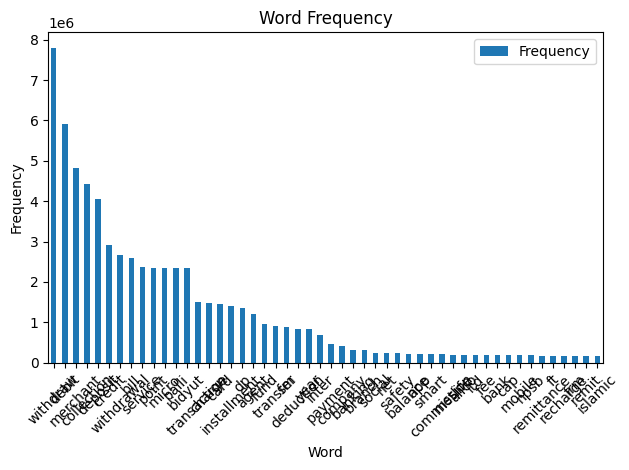

In [21]:
# Top 50 words bar plot
df_freq_top = df_freq[:50]
# Plot the bar chart
plt.figure(figsize=(10, 6))
df_freq_top.plot(kind='bar')
plt.title('Word Frequency')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = data['Tokens'].apply(lambda x: ' '.join(x))  # Convert tokenized words back to string

# Create a TF-IDF vectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the tokenized text
tfidf_matrix = vectorizer.fit_transform(tokens)


In [ ]:
# Get the feature words (vocabulary) and their corresponding TF-IDF scores
feature_words = vectorizer.vocabulary_
print(feature_words)

In [24]:
from sklearn.cluster import KMeans

# Assuming you have a TF-IDF matrix called 'tfidf_matrix' or any other suitable data format
k = 9  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(tfidf_matrix)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=9)

In [25]:
cluster_labels = kmeans.labels_
# Assuming you have a DataFrame called 'df' with the original data
data['Cluster'] = cluster_labels  # Add a 'cluster' column to the DataFrame

# Print the distribution of documents across clusters
print(data['Cluster'].value_counts())


8    3976823
4    3643392
2    2404497
3    2359720
5    2330997
1    2330682
7    2250196
6    1932980
0    1314717
Name: Cluster, dtype: int64


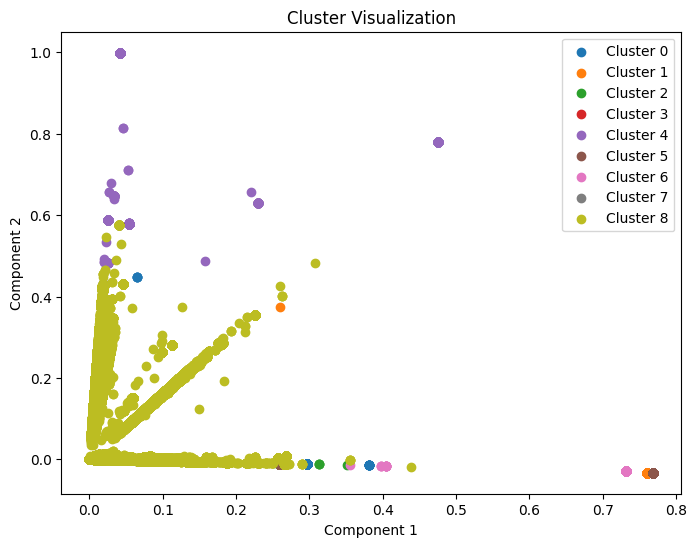

In [26]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Reduce the dimensionality of the data to 2 dimensions using TruncatedSVD
svd = TruncatedSVD(n_components=2)
reduced_features = svd.fit_transform(tfidf_matrix)

# Get the cluster assignments
cluster_labels = kmeans.labels_

# Plot the cluster points
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_points = reduced_features[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title('Cluster Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [27]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Assuming you have a list of tokenized sentences named 'tokens_list'

# # Convert the tokenized sentences into strings
# sentences = [' '.join(tokens) for tokens in data['Tokens']]

# # Initialize the TfidfVectorizer
# vectorizer = TfidfVectorizer()

# # Fit and transform the sentences to obtain the TF-IDF matrix
# tfidf_matrix = vectorizer.fit_transform(sentences)

# # Get the feature words (vocabulary) from the vectorizer
# feature_words = vectorizer.vocabulary_

# # Print the feature words
# print(feature_words)
# print(data.head)

In [28]:
# feature_words_per_row = [list(set(row_tokens) & set(feature_words)) for row_tokens in data['Tokens']]

# # data = data.assign(FeatureWords=[list(set(row_tokens) & set(feature_words)) for row_tokens in data['Tokens']])
# # print(data.head())

# from sklearn.cluster import KMeans

# # Define the number of clusters
# num_clusters = 5
# amounts_array = data['AMOUNT'].to_numpy()

# # Create a feature matrix by combining feature words and amounts
# data_matrix = np.column_stack((feature_words_per_row, amounts_array))

# # Perform K-means clustering
# kmeans = KMeans(n_clusters=num_clusters)
# kmeans.fit(data_matrix)

# # Get the cluster labels
# cluster_labels = kmeans.labels_

# # Assign the cluster labels to your original dataframe
# data['Cluster'] = cluster_labels
# print(data.head())

In [29]:
# from sklearn.cluster import KMeans

# # Define the number of clusters
# num_clusters = 5
# amounts_array = data['AMOUNT'].to_numpy()

# # Create a feature matrix by combining feature words and amounts
# data_matrix = np.column_stack((feature_words_per_row, amounts_array))

# # Perform K-means clustering
# kmeans = KMeans(n_clusters=num_clusters)
# kmeans.fit(data_matrix)

# # Get the cluster labels
# cluster_labels = kmeans.labels_

# # Assign the cluster labels to your original dataframe
# data['Cluster'] = cluster_labels

In [30]:
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.feature_extraction.text import CountVectorizer


# vectorizer = CountVectorizer()

# # Fit and transform the documents to obtain the document-term matrix
# X = vectorizer.fit_transform(data['NARATION'])

# # Initialize the MiniBatchKMeans algorithm
# kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)

# # Fit the algorithm on the document-term matrix
# kmeans.fit(X)

# # Get the cluster labels for each document
# labels = kmeans.labels_
 
# vec = TfidfVectorizer(stop_words="english")
# vec.fit(data.NARATION.values)
# keywords = vec.transform(data.NARATION.values)

In [31]:
# grouped_data2 = data.groupby('AC_ID')

# # Create a new DataFrame with a list of tuples for each distinct 'ac_no'
# grouped_df = pd.DataFrame([(AC_ID, list(zip(group['AMOUNT'], group['DR_CR'], group['TOKENS'])))
#                            for AC_ID, group in grouped_data2],
#                           columns=['AC_ID', 'TRANSACTIONS'])
# grouped_df.head()


In [32]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Assuming 'grouped_df' is the DataFrame containing the 'transactions' column with a list of tuples
# # Assuming the column name is 'transactions'
# # def flat(d) -> str:
# #     l = []
# #     for tuple_item in d:
# #         s = ""
# #         for i in tuple_item:
# #             s = s + " " + str(i)
# #         l.append(s)
# #     return l
                        

# # Flatten the 'transactions' column to create a list of strings
# grouped_df['TRANSACTIONS'] = [[str(' '.join(str(element) for element in tuple_element)) for tuple_element in row] for row in grouped_df['TRANSACTIONS']]

In [33]:
# grouped_df.head()
# Initialize the TfidfVectorizer
# vectorizer = TfidfVectorizer()

# # Compute the TF-IDF features
# tfidf_features = vectorizer.fit_transform(flatten_transactions)
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Assuming you have a dataframe named 'df' with a column 'text' containing the list of strings
# # For example:
# df = pd.DataFrame({'text': [['apple', 'banana', 'orange'], ['grape', 'kiwi']]})
# print(df)

# # Flatten the list of strings within each row
# flattened_text = [word for sublist in df['text'] for word in sublist]
# print(flattened_text)

# # Initialize the TfidfVectorizer
# vectorizer = TfidfVectorizer()

# # Fit and transform the flattened text data to obtain the TF-IDF matrix
# tfidf_matrix = vectorizer.fit_transform(flattened_text)


# # Print the feature words
# print(tfidf_matrix)

In [34]:
# # Convert the TF-IDF features to a DataFrame
# tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names())

# # Print the TF-IDF DataFrame
# tfidf_df.head()